In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [3]:
import scanpy as sc
# import scvelo as scv

# read the full GSE dataset
data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
data.shape

(161764, 33538)

In [4]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [6]:
data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')

label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


## Read features

In [7]:
# Level 1 ADlasso features by loss difference convergence
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Hao_repcells_inv/L1_lossdiff/feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [8]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,11,6
CD4_T,250,104
CD8_T,20,5
DC,26,16
Mono,21,10
NK,34,16
other,10,6
other_T,90,28


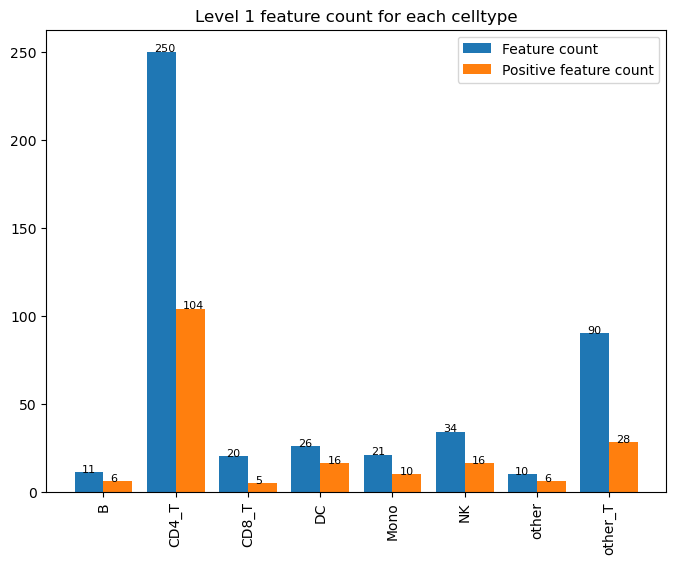

In [57]:
# plot barplot
fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(count_df.index))
bar_width = 0.4

ax.bar(x - bar_width/2, count_df['Feature_count'], bar_width, label='Feature count')
ax.bar(x + bar_width/2, count_df['Positive_feature_count'], bar_width, label='Positive feature count')

# Add the values to each bar
for i, v in enumerate(count_df['Feature_count']):
    plt.text(i-0.3, v, str(v), fontsize=8)
for i, v in enumerate(count_df['Positive_feature_count']):
    plt.text(i+0.1, v, str(v), fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(count_df.index)
plt.xticks(rotation=90)
plt.title('Level 1 feature count for each celltype')
ax.legend()
# plt.savefig('L2_feature_count.png', dpi=300, bbox_inches='tight')
plt.show()

## Build classifiers (K-fold CV)

In [13]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Calculate likelihood
    decision_scores = clf.decision_function(X)  # >0: predict celltype, <0: predict not celltype
    print('decision_scores > 0:', sum(decision_scores > 0))
    likelihood = 1 / (1 + np.exp(-decision_scores))
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype
    print(type(likelihood), likelihood.shape)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics, likelihood

In [33]:
# do it the old way (without kfold)
celltype = 'CD8_T'
# subset data to celltype features
X = data[:, features_dict[celltype]['Gene'].tolist()].X
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)
mcc = matthews_corrcoef(y_test, y_pred)

metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]
metrics

[0.9706673260594072,
 0.9209831403615681,
 0.8900667451904201,
 0.9052610562044524,
 0.9884516012570196,
 0.9585112851124526,
 0.8880955201433167]

In [19]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Hao_repcells_inv/L1_lossdiff')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
likelihood_dict = {}

for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics, like = LR_kfold(data, features_dict, celltype, k=5)  # metrics is a list
    likelihood_dict[celltype] = like
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    filename = f'LR_{celltype}_loss_diff_l1.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


K-fold CV for: B
decision_scores > 0: 13762
likelihood > 0.5: 13762
<class 'numpy.ndarray'> (161764,)
[0.9983494491389389, 0.9917925752972199, 0.9888405797101448, 0.9903031197487515, 0.9998669407650119, 0.9991828148839119, 0.9894091150866142]
K-fold CV for: CD4_T


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


decision_scores > 0: 40958
likelihood > 0.5: 40958
<class 'numpy.ndarray'> (161764,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[0.9667478890596783, 0.9356850963122895, 0.9350506095330433, 0.9347427054849907, 0.9937666655751128, 0.9822891453359753, 0.912996904327167]
K-fold CV for: CD8_T
decision_scores > 0: 24595
likelihood > 0.5: 24595
<class 'numpy.ndarray'> (161764,)
[0.9700057057130321, 0.9192352902179323, 0.8875111385242731, 0.9029730112742808, 0.9876197536279097, 0.9561591026087808, 0.8855164528138287]
K-fold CV for: DC
decision_scores > 0: 3552
likelihood > 0.5: 3552
<class 'numpy.ndarray'> (161764,)
[0.9979785370918964, 0.9595255906115409, 0.949011472282763, 0.9541949318295279, 0.999423554717463, 0.9891327495756391, 0.9531998979312466]
K-fold CV for: Mono
decision_scores > 0: 49934
likelihood > 0.5: 49934
<class 'numpy.ndarray'> (161764,)
[0.9911290493319507, 0.976483286367513, 0.9946949602122015, 0.9854976624832688, 0.9978025532744181, 0.9920656920085836, 0.9792031320739432]
K-fold CV for: NK
decision_scores > 0: 18657
likelihood > 0.5: 18657
<class 'numpy.ndarray'> (161764,)
[0.9903068569706278, 0.95

In [20]:
likelihood_dict

{'B': array([7.69025544e-06, 2.00923030e-06, 9.09836221e-06, ...,
        9.99976659e-01, 4.00825310e-04, 9.95553456e-05]),
 'CD4_T': array([2.03427752e-05, 9.91685620e-01, 4.57902239e-03, ...,
        3.33437049e-04, 8.99213579e-05, 7.67507224e-05]),
 'CD8_T': array([6.52224823e-04, 1.91976681e-02, 9.98602081e-01, ...,
        1.25748308e-03, 1.53870251e-04, 1.08448955e-03]),
 'DC': array([9.44491048e-06, 1.90667362e-15, 1.01422086e-14, ...,
        3.11886594e-07, 2.09970904e-02, 1.44097112e-03]),
 'Mono': array([9.46619413e-01, 6.87920860e-10, 1.52756044e-11, ...,
        6.70574661e-04, 9.77267270e-01, 9.59569654e-01]),
 'NK': array([1.64016024e-06, 2.58608324e-06, 1.15109523e-05, ...,
        7.75247214e-07, 1.06072513e-05, 4.52828424e-05]),
 'other': array([0.00133669, 0.00210685, 0.00176519, ..., 0.00786865, 0.00869286,
        0.001368  ]),
 'other_T': array([8.02910628e-05, 1.02568865e-03, 4.93039032e-03, ...,
        1.11263291e-06, 4.48544337e-06, 3.19645945e-05])}

In [41]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
0,7.690255e-06,0.000020,0.000652,9.444910e-06,9.466194e-01,1.640160e-06,0.001337,0.000080
1,2.009230e-06,0.991686,0.019198,1.906674e-15,6.879209e-10,2.586083e-06,0.002107,0.001026
2,9.098362e-06,0.004579,0.998602,1.014221e-14,1.527560e-11,1.151095e-05,0.001765,0.004930
3,3.024548e-06,0.000034,0.008927,1.481265e-14,6.729984e-10,9.999334e-01,0.001682,0.004057
4,1.233225e-07,0.001336,0.991165,1.538095e-19,1.702555e-07,2.281867e-07,0.002409,0.002142


In [44]:
likelihood_df.to_csv('L1_likelihood_df.csv')

In [21]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.998349,0.991793,0.988841,0.990303,0.999867,0.999183,0.989409
CD4_T,0.966748,0.935685,0.935051,0.934743,0.993767,0.982289,0.912997
CD8_T,0.970006,0.919235,0.887511,0.902973,0.987620,0.956159,0.885516
DC,0.997979,0.959526,0.949011,0.954195,0.999424,0.989133,0.953200
Mono,0.991129,0.976483,0.994695,0.985498,0.997803,0.992066,0.979203
NK,0.990307,0.958617,0.957780,0.958065,0.998585,0.991393,0.952671
other,0.990715,0.887518,0.646920,0.730090,0.933580,0.782896,0.743742
other_T,0.982796,0.847181,0.719686,0.778161,0.985697,0.853883,0.772090


In [23]:
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_loss_diff_l1.csv')

## Plot likelihood odds ratio confusion matrix

In [45]:
largest_values = []
second_largest_values = []
largest_columns = []
second_largest_columns = []
odds_ratio_list = []
assignments = []

# for index, row in likelihood_softmax.iterrows():
for index, row in likelihood_df.iterrows():
    # find 1st and 2nd largest values and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    second_largest_value = row.nlargest(2).iloc[-1]
    second_largest_column = row.nlargest(2).index[-1]
    
    largest_values.append(largest_value)
    second_largest_values.append(second_largest_value)
    largest_columns.append(largest_column)
    second_largest_columns.append(second_largest_column)

    # calculate odds ratio
    odds_ratio = largest_value / second_largest_value
    if odds_ratio >= 1.5:
        assign = largest_column
    else:
        assign = 'Uncertain'
    odds_ratio_list.append(odds_ratio)
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns,
                          'Second Largest Value': second_largest_values, 'Second Largest Column': second_largest_columns, 
                          'Odds Ratio': odds_ratio_list, 'Assignment': assignments})
result_df.shape


(161764, 6)

In [46]:
result_df.head(20)

,Largest Value,Largest Column,Second Largest Value,Second Largest Column,Odds Ratio,Assignment
0,0.946619,Mono,0.001337,other,708.179692,Mono
1,0.991686,CD4_T,0.019198,CD8_T,51.656567,CD4_T
2,0.998602,CD8_T,0.004930,other_T,202.540168,CD8_T
3,0.999933,NK,0.008927,CD8_T,112.010118,NK
4,0.991165,CD8_T,0.002409,other,411.386695,CD8_T
5,0.573299,CD8_T,0.006454,other_T,88.832798,CD8_T
6,0.986463,Mono,0.002810,other,351.091665,Mono
7,0.997439,B,0.002123,CD4_T,469.921149,B
8,0.999477,NK,0.024347,other_T,41.051611,NK
9,0.999399,CD8_T,0.016905,CD4_T,59.118617,CD8_T


In [47]:
sum(result_df['Assignment'] == 'Uncertain')

4779

In [49]:
4779/len(result_df)

0.029543038005984026

In [53]:
import pandas as pd

# Get the true labels
true_labels = data.obs['celltype.l1'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)
cm.to_csv('L1_LR_confusion_matrix.csv')


In [54]:
cm

Predicted,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T,Uncertain
True,,,,,,,,,
B,13693,0,3,0,5,2,11,1,85
CD4_T,2,39830,200,0,3,9,10,160,787
CD8_T,0,748,22480,0,1,81,4,302,1853
DC,1,1,0,3108,135,0,4,0,340
Mono,2,17,9,18,48663,5,46,1,249
NK,2,14,43,0,3,18293,1,45,263
other,28,168,40,1,585,27,2422,34,137
other_T,2,237,519,0,0,127,0,4839,1065


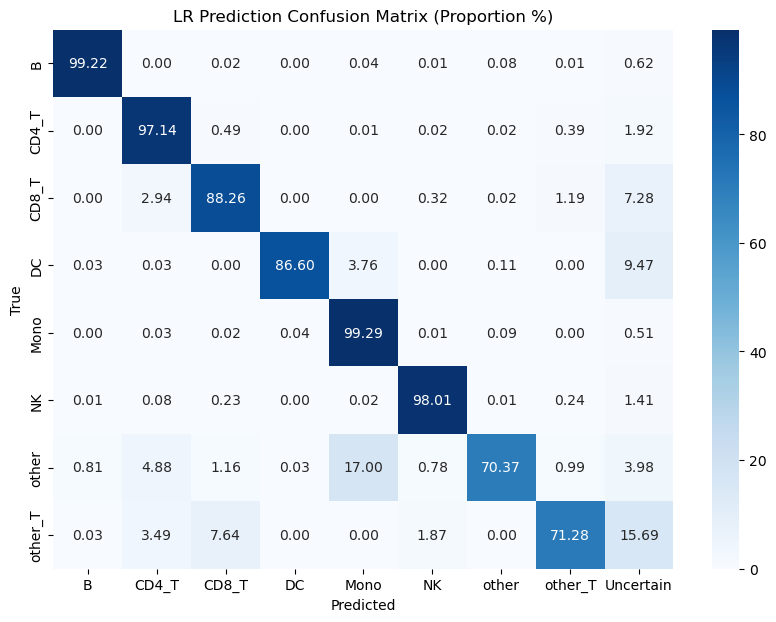

In [55]:
import seaborn as sns

row_sum = cm.sum(axis=1)
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(10, 7))
sns.heatmap(cm_proportion, fmt=".2f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.show()

In [56]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.9478499542543458

## Plot classifier K-fold CV metrics

In [ ]:
# line graph

# Plot metrics for each celltype
ax = all_metrics.plot.line(rot=0, figsize=(8, 6), title='One vs. Rest Logistic Regression using ADlasso features (converge by loss difference)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylim(0, 1.1)

# Generate x-ticks for every data point
plt.xticks(np.arange(len(all_metrics.index)), all_metrics.index, rotation=90)
plt.show()

# only plot important metrics
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = all_metrics[cols].plot.line(rot=0, figsize=(8, 6), title='One vs. Rest Logistic Regression using ADlasso features (converge by loss difference)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylim(0, 1.1)

# Generate x-ticks for every data point
plt.xticks(np.arange(len(all_metrics.index)), all_metrics.index, rotation=90)
plt.show()

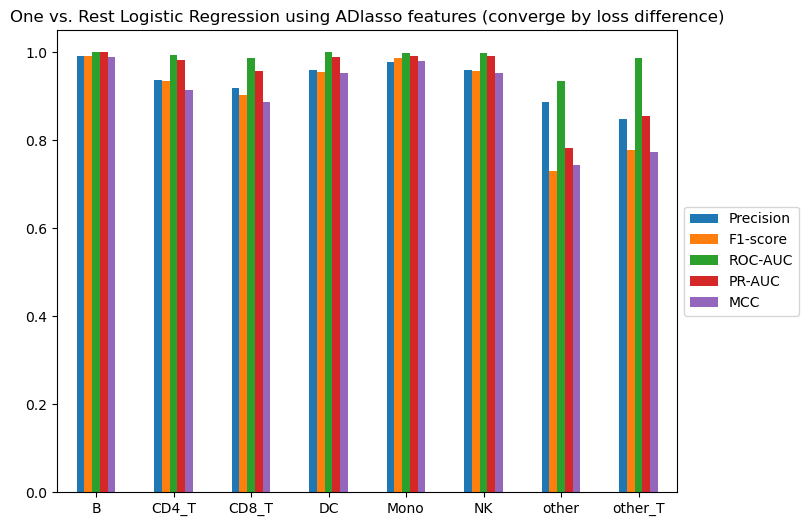

In [26]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=0, figsize=(8,6), title='One vs. Rest Logistic Regression using ADlasso features (converge by loss difference)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Evaluate by DEGn

In [27]:
count_df

,Feature_count,Positive_feature_count
B,11,6
CD4_T,250,104
CD8_T,20,5
DC,26,16
Mono,21,10
NK,34,16
other,10,6
other_T,90,28


In [28]:
# Read DEG table
os.chdir("/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table")

celltype = 'B'
DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
n_features = count_df.loc[celltype, 'Feature_count']  # 3902
DEGn = DEG_table['names'][:n_features].tolist()

In [29]:
n_features

11

In [30]:
DEGn

['CD79A',
 'MS4A1',
 'RALGPS2',
 'BANK1',
 'CD79B',
 'CD74',
 'CD37',
 'HLA-DRA',
 'HLA-DQA1',
 'TNFRSF13C',
 'HLA-DPB1']

In [31]:
def LR_classifier(data, DEGn, celltype):
    # subset data to DEGs
    X = data[:, DEGn].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    # print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)
    # print("Precision: {:.2f}%".format(precision * 100))
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # print("F1: {:.2f}%".format(f1 * 100))
    roc_auc = roc_auc_score(y_test, y_score)
    # print('ROC-AUC:', roc_auc)
    average_precision = average_precision_score(y_test, y_score)  # PR-AUC
    mcc = matthews_corrcoef(y_test, y_pred)

    # model metrics
    metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]

    return clf, metrics

In [33]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist()

    clf, celltype_metrics = LR_classifier(data, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics

Constructing classifier for: B
n: 11
(161764, 11)
Constructing classifier for: CD4_T
n: 250
(161764, 250)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Constructing classifier for: CD8_T
n: 20
(161764, 20)
Constructing classifier for: DC
n: 26
(161764, 26)
Constructing classifier for: Mono
n: 21
(161764, 21)
Constructing classifier for: NK
n: 34
(161764, 34)
Constructing classifier for: other
n: 10
(161764, 10)
Constructing classifier for: other_T
n: 90
(161764, 90)


In [34]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.998578,0.994173,0.989130,0.991645,0.999482,0.998402,0.990872
CD4_T,0.941644,0.885348,0.884268,0.884808,0.982667,0.950363,0.845732
CD8_T,0.969678,0.912207,0.893404,0.902708,0.986615,0.953434,0.884818
DC,0.996847,0.935028,0.922006,0.928471,0.998010,0.974356,0.926883
Mono,0.991593,0.977168,0.995511,0.986254,0.997475,0.989797,0.980288
NK,0.986060,0.939240,0.939995,0.939617,0.997503,0.983078,0.931738
other,0.991005,0.883946,0.664244,0.758506,0.910034,0.777275,0.762020
other_T,0.980465,0.825269,0.678203,0.744543,0.979187,0.822043,0.738314


In [35]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Hao_repcells_inv/L1_lossdiff')
all_metrics_DEG.to_csv('L1_loss_diff_DEGn_metrics.csv')

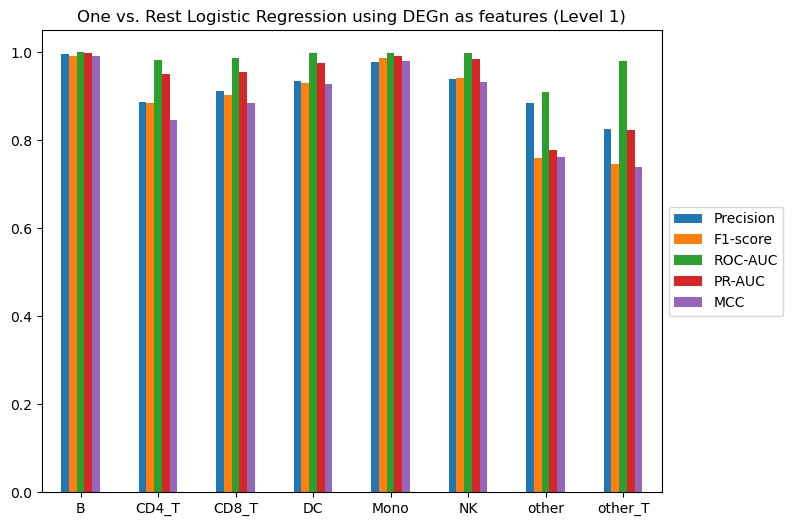

In [36]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
# Plot metrics for each celltype
ax = all_metrics_DEG[cols].plot.bar(rot=0, figsize=(8,6), title='One vs. Rest Logistic Regression using DEGn as features (Level 1)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Combine plots: ADlasso features vs. DEG

In [37]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.998349,0.991793,0.988841,0.990303,0.999867,0.999183,0.989409
CD4_T,0.966748,0.935685,0.935051,0.934743,0.993767,0.982289,0.912997
CD8_T,0.970006,0.919235,0.887511,0.902973,0.987620,0.956159,0.885516
DC,0.997979,0.959526,0.949011,0.954195,0.999424,0.989133,0.953200
Mono,0.991129,0.976483,0.994695,0.985498,0.997803,0.992066,0.979203
NK,0.990307,0.958617,0.957780,0.958065,0.998585,0.991393,0.952671
other,0.990715,0.887518,0.646920,0.730090,0.933580,0.782896,0.743742
other_T,0.982796,0.847181,0.719686,0.778161,0.985697,0.853883,0.772090


In [38]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.998578,0.994173,0.989130,0.991645,0.999482,0.998402,0.990872
CD4_T,0.941644,0.885348,0.884268,0.884808,0.982667,0.950363,0.845732
CD8_T,0.969678,0.912207,0.893404,0.902708,0.986615,0.953434,0.884818
DC,0.996847,0.935028,0.922006,0.928471,0.998010,0.974356,0.926883
Mono,0.991593,0.977168,0.995511,0.986254,0.997475,0.989797,0.980288
NK,0.986060,0.939240,0.939995,0.939617,0.997503,0.983078,0.931738
other,0.991005,0.883946,0.664244,0.758506,0.910034,0.777275,0.762020
other_T,0.980465,0.825269,0.678203,0.744543,0.979187,0.822043,0.738314


In [39]:
AD_minus_DEG = all_metrics - all_metrics_DEG
AD_minus_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,-0.000229,-0.002381,-0.000290,-0.001342,0.000385,0.000780,-0.001463
CD4_T,0.025104,0.050337,0.050782,0.049935,0.011099,0.031927,0.067265
CD8_T,0.000327,0.007028,-0.005893,0.000265,0.001004,0.002725,0.000699
DC,0.001131,0.024497,0.027006,0.025724,0.001413,0.014777,0.026317
Mono,-0.000464,-0.000685,-0.000816,-0.000757,0.000328,0.002268,-0.001084
NK,0.004247,0.019377,0.017785,0.018448,0.001082,0.008314,0.020933
other,-0.000291,0.003572,-0.017324,-0.028416,0.023547,0.005621,-0.018278
other_T,0.002330,0.021912,0.041482,0.033618,0.006510,0.031839,0.033776


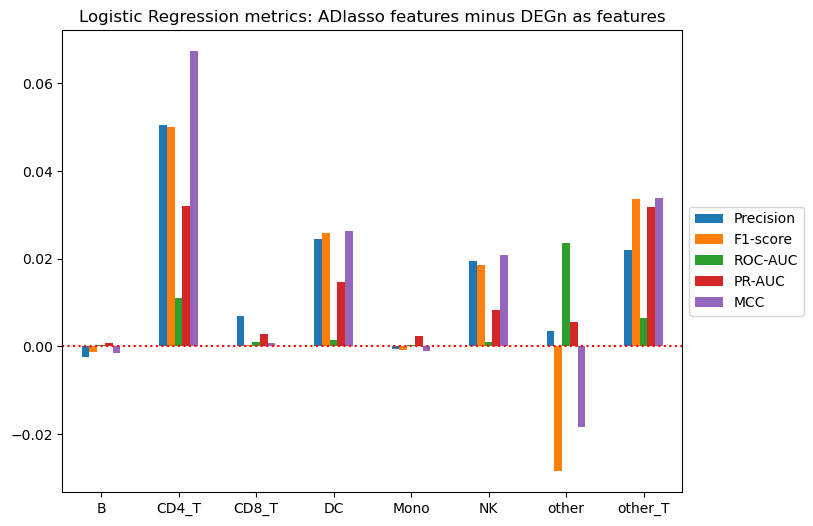

In [40]:
# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = AD_minus_DEG[cols].plot.bar(rot=0, figsize=(8,6), title='Logistic Regression metrics: ADlasso features minus DEGn as features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Add vertical red dotted line at y = 0
ax.axhline(y=0, color='red', linestyle='dotted')
